#### **Lens Model**

**DESIJ0136-0008**

**Author:** Sulyman Hossain, Fahim Rajit Hossain, Akbar, Anowar Shajib

**Acknowledgement:** 

In [4]:
# import of standard python libraries
!pip install emcee
import emcee
!pip install corner
import corner
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import joblib
import shutil

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q, shear_cartesian2polar

from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
"""src_path = r"/kaggle/input/akbars-output-filesfinal/mcmc_backend.h5"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)"""

'src_path = r"/kaggle/input/akbars-output-filesfinal/mcmc_backend.h5"\ndst_path = r"/kaggle/working/"\nshutil.copy(src_path, dst_path)'

## Loading data for Model

In [6]:
with h5py.File("DESIJ0136-0008_F140W.h5", "r") as f:
    kwargs_data = {}

    for key in f:
        if key == "exposure_time":
            kwargs_data[key] = f[key][()]
            continue
        kwargs_data[key] = f[key][()]

# print kwargs_data
for key in kwargs_data:
    print(f"{key}: {kwargs_data[key]}")

background_rms: 0.020226480636773847
dec_at_xy_0: -10.03999999999999
exposure_time: [[480.17502 478.00955 545.1479  ... 453.76492 495.06876 351.65335]
 [539.82275 396.43954 378.49487 ... 577.67755 321.1616  305.41653]
 [347.75266 582.9625  483.96677 ... 425.66187 318.69778 337.77414]
 ...
 [431.28677 453.53516 507.60822 ... 417.27905 406.37323 441.34796]
 [373.92175 272.3933  383.2737  ... 431.20264 502.59534 595.19434]
 [392.85666 451.82388 520.1835  ... 609.24677 391.4596  412.2425 ]]
image_data: [[-0.01320017  0.00887198  0.01452675 ... -0.00496921 -0.00073036
   0.01501495]
 [-0.008774    0.02328778  0.00136724 ... -0.04160036  0.0106275
   0.00662912]
 [-0.03182266 -0.00972193  0.00459631 ... -0.01573473  0.0048767
   0.00191049]
 ...
 [ 0.00095618  0.01111637  0.00379965 ...  0.01628057  0.00888098
  -0.01454695]
 [ 0.00781532 -0.00317025  0.01218377 ...  0.00941897 -0.00657219
  -0.0251791 ]
 [ 0.00606052  0.00711807  0.01721074 ...  0.05797264 -0.00717967
  -0.02253795]]
ra_at_

In [7]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"
print(kwargs_psf)

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
        3.2385867e-06, 4.4331632e-06],
       [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
        6.6143798e-06, 4.1430776e-06],
       [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
        5.1404800e-06, 1.7530243e-06],
       ...,
       [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
        5.3933368e-06, 1.6360833e-06],
       [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
        8.7221979e-06, 3.7005334e-06],
       [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
        3.2246478e-06, 5.1252514e-06]], dtype=float32), 'psf_type': 'PIXEL'}


/tmp/ipykernel_12574/2469112303.py:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


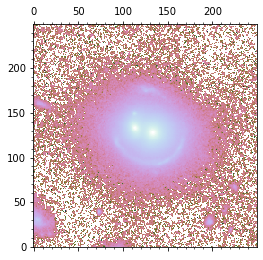

In [8]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
#plt.grid(which="both", color="black")
plt.minorticks_on()
#plt.grid(which="minor", color="black")


# plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');

### Masking

/tmp/ipykernel_12574/2401902451.py:108: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image_data), origin="lower", cmap="cubehelix")
/tmp/ipykernel_12574/2401902451.py:120: RuntimeWarning: divide by zero encountered in log10
  image_after_mask = np.log10(image_data * mask)
/tmp/ipykernel_12574/2401902451.py:120: RuntimeWarning: invalid value encountered in log10
  image_after_mask = np.log10(image_data * mask)


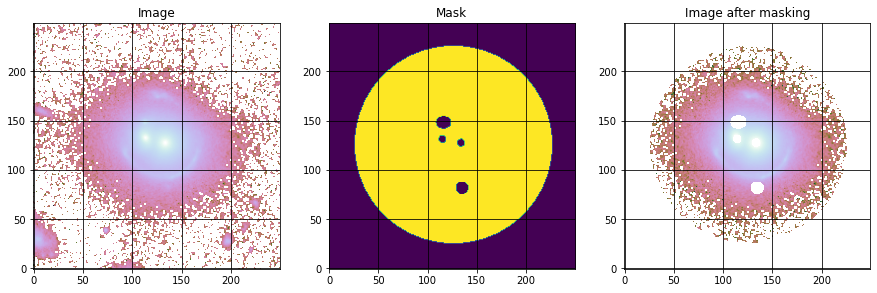

In [9]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 8  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


# for the galaxy at 11 o clock
mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.8,
    lens_center_dec + 1.8,
    0.6,
    0.5,
    0,
)

# for the blob at 12 o clock
mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra -0.5,
    lens_center_dec + 4,
    2,
    1,
    np.pi+0.3,
)

# EPL Center
mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.62,
    lens_center_dec + 0.153,
    0.3,
    0.3,
    0,
)

# Satellite Center
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.9,
    lens_center_dec + 0.45,
    0.3,
    0.3,
    0,
)

# For removing the extra light
mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
   lens_center_ra + 0.5,
    lens_center_dec - 0.6,
    0.35,
    0.75,
    0.78,
)

# 6 o'clock object
mask_ext_6 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
   lens_center_ra - 0.7,
    lens_center_dec - 3.5,
    0.5,
    0.5,
    0,
)



mask = ((1 - mask_outer)
* (1 - mask_ext_1) 
#* (1 - mask_ext_2)
* (1 - mask_ext_3)
* (1 - mask_ext_4)
#* (1 - mask_ext_5)
* (1 - mask_ext_6)

       )
mask[mask >= 1] = 1
mask[mask < 0] = 0
mask = mask.reshape(num_pix, num_pix)


# Setting the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(np.log10(image_data), origin="lower", cmap="cubehelix")
axes[0].grid(True, color="black")
# axes[0].minorticks_on()
# axes[0].grid(which='minor', color='black')
axes[0].set_title("Image")


axes[1].imshow(mask, origin="lower")
axes[1].grid(True, color="black")
axes[1].set_title("Mask")


image_after_mask = np.log10(image_data * mask)

axes[2].imshow(image_after_mask, origin="lower", cmap="cubehelix")
axes[2].grid(True, color="black")
axes[2].set_title("Image after masking")


# Show the plots
plt.show()

In [10]:
lens_model_list = ["EPL",
                   "SHEAR",
                   "SIE",
 #                  "FLEXION",
                  ]
source_model_list = ["SERSIC_ELLIPSE",
                     "SHAPELETS",
#                     "SHAPELETS",
                    ]
lens_light_model_list = ["SERSIC_ELLIPSE",
                         "SERSIC_ELLIPSE",
                         "SERSIC_ELLIPSE",
                        ]

## Lens galaxy's mass model

In [11]:
# Lens parameter

# EPL 1

lens_center_x = -0.426
lens_center_y = 1.413
lens_centroid_bound = 0.5

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})

kwargs_lens_init.append(
     {
        "theta_E": 2.729,
        "gamma": 2,
        "e1": -0.27,
        "e2": 0.19,
        "center_x": lens_center_x,
        "center_y": lens_center_y,
    }
)

kwargs_lens_sigma.append(
    {
        "theta_E": 0.3,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": lens_centroid_bound / 4,
        "center_y": lens_centroid_bound / 4,
    }
)

kwargs_lower_lens.append(
    {
        "theta_E": 2.,
        "gamma": 1.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": lens_center_x - lens_centroid_bound,
        "center_y": lens_center_y - lens_centroid_bound,
    }
)

kwargs_upper_lens.append(
    {
        "theta_E": 5.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": lens_center_x + lens_centroid_bound,
        "center_y": lens_center_y + lens_centroid_bound,
    }
)

# SHEAR 


fixed_lens.append({"ra_0": 0.0, "dec_0": 0.0})  # Shear
kwargs_lens_init.append({"gamma1": -0.0961,       #0.0
                         "gamma2":  0.11040,
                         "ra_0": 0.0,
                         "dec_0": 0.0})  #0.0

kwargs_lens_sigma.append({"gamma1": 0.05,
                          "gamma2": 0.05,
                          "ra_0": 0.1,
                          "dec_0": 0.1})  # Changed

kwargs_lower_lens.append({"gamma1": -0.3,
                          "gamma2": -0.3,
                         "ra_0": -10,
                         "dec_0": -10})

kwargs_upper_lens.append({"gamma1": 0.3,
                          "gamma2": 0.3,
                         "ra_0": 10,
                         "dec_0": 10})


### SIE left one

In [12]:
# SIE parameter


satellite_center_x = 0.9480
satellite_center_y = 0.5488
satellite_centroid_bound = 0.5

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 0.594,
        "e1": -0.123,
        "e2": 0.0704, #0.16
        "center_x": satellite_center_x,
        "center_y": satellite_center_y,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": satellite_centroid_bound / 4,
        "center_y": satellite_centroid_bound / 4,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.0001,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": satellite_center_x - satellite_centroid_bound,
        "center_y": satellite_center_y - satellite_centroid_bound,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 5.,  #2.0
        "e1": 0.5,
        "e2": 0.5,
        "center_x": satellite_center_x + satellite_centroid_bound,
        "center_y": satellite_center_y + satellite_centroid_bound,
    }
)


"""# FLEXION
fixed_lens.append({"ra_0": 0., "dec_0": 0.})
kwargs_lens_init.append(
    {
        "g1": 0.0,
        "g2": 0.0,
        "g3": 0.0,
        "g4": 0.0,
        "ra_0": 0.0,
        "dec_0": 0.0
    }
)
kwargs_lens_sigma.append({"g1": 0.01, "g2": 0.01, "g3": 0.01, "g4": 0.01,
                          "ra_0": 0., "dec_0": 0.})
kwargs_lower_lens.append({"g1": -0.1, "g2": -0.1, "g3": -0.1, "g4": -0.1,
                         "ra_0": 0., "dec_0": 0.})
kwargs_upper_lens.append({"g1": 0.1, "g2": 0.1, "g3": 0.1, "g4": 0.1,
                         "ra_0": 0., "dec_0": 0.})"""


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

## Source galaxy's light model

In [13]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

source1_bound = 0.5
# Source's position in lens plane
source1_x = -0.5   # 1
source1_y = +4.0   # 1.8


fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.2125,
        "n_sersic": 1.0,
        "e1": -0.4688,
        "e2": -0.038,
        "center_x": source1_x,
        "center_y": source1_y,
        "amp": 10,
    }
)

kwargs_source_sigma.append(
    {
        "R_sersic": 0.1,
        "n_sersic": 0.5,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": source1_bound/4,
        "center_y": source1_bound/4,
        "amp": 10,
    }
)

kwargs_lower_source.append(
    {
        "R_sersic": 0.04,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": source1_x - source1_bound,
        "center_y": source1_y - source1_bound,
        "amp": 0,
    }
)

kwargs_upper_source.append(
    {
        "R_sersic": 0.3,
        "n_sersic": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": source1_x + source1_bound,
        "center_y": source1_y + source1_bound,
        "amp": 100,
    }
)



## Shapelets

In [14]:
# 1st Shapelets


fixed_source.append({"n_max": 10})
kwargs_source_init.append({"beta": 0.1,
                           "center_x":  source1_x,
                           "center_y":  source1_y})

kwargs_source_sigma.append({"beta": 0.05,
                            "center_x": source1_bound/4,
                            "center_y": source1_bound/4})

kwargs_lower_source.append({"beta": 0.001,  #0.1
                            "center_x": source1_x - source1_bound,
                            "center_y": source1_y - source1_bound})

kwargs_upper_source.append({"beta": 0.25,
                            "center_x": source1_x + source1_bound,
                            "center_y": source1_y + source1_bound})

joint_shapelets_with_sersic = [[0, 1, ["center_x", "center_y"]]]


"""# 2nd Shapelets

source2_bound = 0.5
source2_x = -0.5   # -0.5
source2_y = +4.0   # -2
fixed_source.append({"n_max": 10})
kwargs_source_init.append({"beta": 0.05,
                           "center_x":  source2_x,
                           "center_y":  source2_y})

kwargs_source_sigma.append({"beta": 0.05,
                            "center_x": source2_bound/4,
                            "center_y": source2_bound/4})

kwargs_lower_source.append({"beta": 0.001,  #0.1
                            "center_x": source2_x - source2_bound,
                            "center_y": source2_y - source2_bound})

kwargs_upper_source.append({"beta": 0.15,
                            "center_x": source2_x + source2_bound,
                            "center_y": source2_y + source2_bound})"""

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

## Lens galaxy Light Model

In [15]:
# Lens Galaxy

# 1st Sersic

fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []



fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic":  1.935,
        "n_sersic": 1.0,
        "e1": 0.249,
        "e2": 0.0485,
        "center_x": -0.65044,
        "center_y": 0.149,
        "amp": 16,
    }
)


kwargs_lens_light_sigma.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)

kwargs_lower_lens_light.append(
    {
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_lens_light.append(
    {
        "R_sersic": 10,
        "n_sersic": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# 2nd sersic ellipse params

fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic":  0.722,
        "n_sersic": 4.0,
        "e1": -0.033,
        "e2": 0.0295,
        "center_x": -0.6504,
        "center_y":  0.14983,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.4,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# Satellite Galaxy

# 3rd Sersic

fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic":  0.448,
        "n_sersic": 4,
        "e1": -0.12,
        "e2": 0.070,
        "center_x": satellite_center_x,
        "center_y": satellite_center_y,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": satellite_centroid_bound / 4,
        "center_y": satellite_centroid_bound / 4,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": satellite_center_x - satellite_centroid_bound,
        "center_y": satellite_center_y - satellite_centroid_bound,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": satellite_center_x + satellite_centroid_bound,
        "center_y": satellite_center_y + satellite_centroid_bound,
        "amp": 100,
    }
)



joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]
joint_lens_with_light = [
#                        [0, 0, ["center_x", "center_y"]],
                        [2, 2, ["center_x", "center_y", "e1", "e2"]],
                        ]


lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

In [16]:
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_shapelets_with_sersic,
    "joint_lens_with_light": joint_lens_with_light,
    "image_plane_source_list": [True, True],
}

## Log Likelihood Addition

In [17]:
def custom_log_likelihood_addition(
    kwargs_lens=None,
    kwargs_source=None,
    kwargs_lens_light=None,
    kwargs_ps=None,
    kwargs_special=None,
    kwargs_extinction=None,
):
    """

    :param kwargs_lens: lens mass model keywords

    :type kwargs_lens: list

    :param kwargs_source: source light model keywords

    :type kwargs_source: list

    :param kwargs_lens_light: lens light model keywords

    :type kwargs_lens_light:  list

    :param kwargs_ps: point source keywords

    :type kwargs_ps: list

    :param kwargs_special: special keywords

    :type kwargs_special: list

    :param kwargs_extinction: extinction model keywords

    :type kwargs_extinction: list

    :return: custom log_likelihood

    :rtype: float

    """

    log_likelihood = 0.0

    mass_phi, mass_q = ellipticity2phi_q(kwargs_lens[0]["e1"], kwargs_lens[0]["e2"])
    light_phi, light_q = ellipticity2phi_q(
        kwargs_lens_light[0]["e1"], kwargs_lens_light[0]["e2"]
    )

    gaussian_std = 0.01
    if mass_q < light_q:
        log_likelihood += -0.5 * (mass_q - light_q) ** 2 / gaussian_std**2

    return log_likelihood

In [18]:
kwargs_likelihood = {"custom_logL_addition": custom_log_likelihood_addition,
                     "check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

In [19]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## **Here model fitting is done**

In [20]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["update_settings", {"lens_add_fixed": [[0, ["gamma"]]]}],
    ["PSO", {"sigma_scale": 1.0, "n_particles": 10, "n_iterations": 10}],
    ["update_settings", {"lens_remove_fixed": [[0, ["gamma"]]]}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
Max iteration reached! Stopping.
-1.0207945673000554 reduced X^2 of best position
-15809.045463775958 log likelihood
30974 effective number of data points
[{'theta_E': 2.729, 'gamma': 2, 'e1': -0.27, 'e2': 0.19, 'center_x': -0.426, 'center_y': 1.413}, {'gamma1': -0.0961, 'gamma2': 0.1104, 'ra_0': 0.0, 'dec_0': 0.0}, {'theta_E': 0.594, 'e1': -0.12, 'e2': 0.07, 'center_x': 0.948, 'center_y': 0.5488}] lens result
[{'amp': 1, 'R_sersic': 0.2125, 'n_sersic': 1.0, 'e1': -0.4688, 'e2': -0.038, 'center_x': -0.20924066964126725, 'center_y': 0.7491994130742268}, {'amp': 1, 'n_max': 10, 'beta': 0.1, 'center_x': -0.20924066964126725, 'center_y': 0.7491994130742268}] source result
[{'amp': 1, 'R_sersic': 1.935, 'n_sersic': 1.0, 'e1': 0.249, 'e2': 0.0485, 'center_x': -0.65044, 'center_y': 0.149}, {'amp': 1, 'R_sersic': 0.722, 'n_sersic': 4.0, 'e1': -0.033, 'e2': 0.0295, 'center_x': -0.65044, 'center_y': 0.149}, {'amp': 1, 'R_sersic': 0.448, 'n_sersic': 4.0, 'e1': -0.12, 'e2'

In [21]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "DESIJ0136-0008_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

# Visualizating the fitted Model

-1.0149004746174826 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0149004746174832


/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


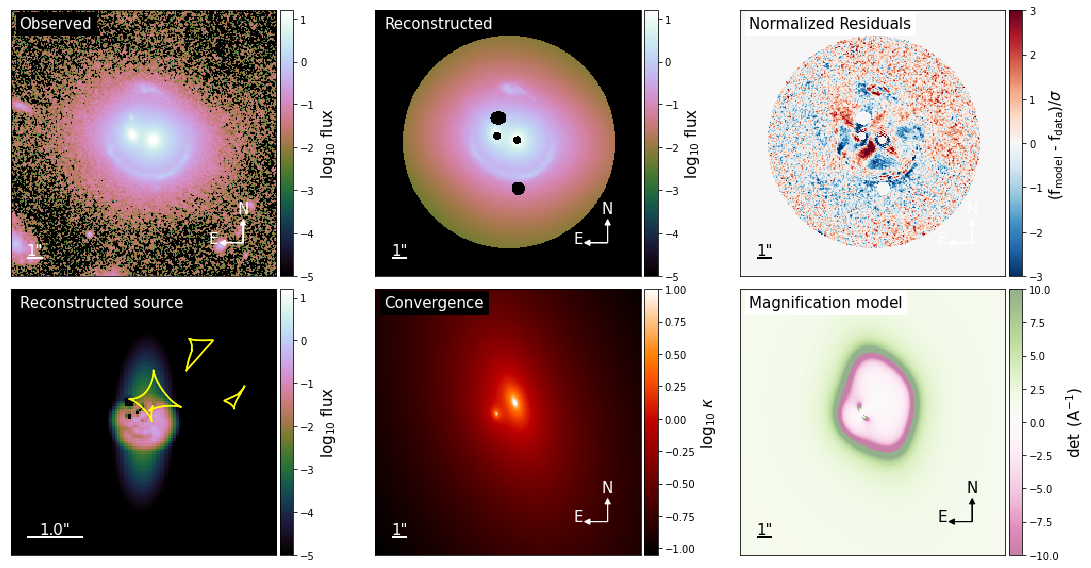

/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: divide by zero encountered in log10
  np.log10(model),


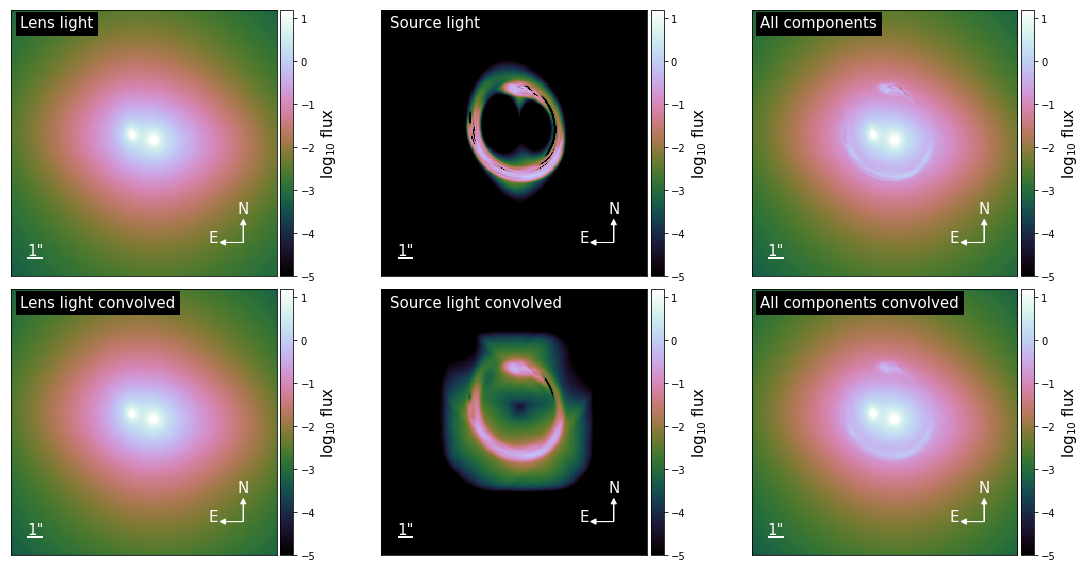

{'kwargs_lens': [{'theta_E': 2.729, 'gamma': 2, 'e1': -0.27, 'e2': 0.19, 'center_x': -0.426, 'center_y': 1.413}, {'gamma1': -0.0961, 'gamma2': 0.1104, 'ra_0': 0.0, 'dec_0': 0.0}, {'theta_E': 0.594, 'e1': -0.12, 'e2': 0.07, 'center_x': 0.948, 'center_y': 0.5488}], 'kwargs_source': [{'amp': 2.3586513422712057, 'R_sersic': 0.2125, 'n_sersic': 1.0, 'e1': -0.4688, 'e2': -0.038, 'center_x': -0.20924066964126725, 'center_y': 0.7491994130742268}, {'amp': array([156.77988397, -26.10741168, -33.20640161, 132.86305488,
        40.5349998 ,  79.69385342, -63.82234396, -33.42784705,
       -49.73098596, -34.95389822,  98.82393606,   2.8514395 ,
        55.42932865,   1.59782816,  25.52572717, -48.86831068,
        -4.14989853, -76.77280818, -43.25655533, -26.12377465,
       -23.18464072,  56.44880011,  -9.18273991,  75.48394134,
        20.3260169 ,  43.23067791,  10.85294093,  14.76703455,
       -25.6682033 ,  -6.53651254, -32.33799345, -13.30754987,
        -1.12069507,   6.20824525,  -3.013754

In [22]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, numPix=100, with_caustics=True, scale_size=1
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

## Mass and Light Ellipticity of the Lens Galaxy afte the PSO-run

In [23]:
result_mass_e1 = kwargs_result["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result["kwargs_lens"][0]["e2"]

result_light0_e1 = kwargs_result["kwargs_lens_light"][0]["e1"]
result_light0_e2 = kwargs_result["kwargs_lens_light"][0]["e2"]

result_light1_e1 = kwargs_result["kwargs_lens_light"][1]["e1"]
result_light1_e2 = kwargs_result["kwargs_lens_light"][1]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light0_phi, light0_q = ellipticity2phi_q(result_light0_e1, result_light0_e2)
light1_phi, light1_q = ellipticity2phi_q(result_light1_e1, result_light1_e2)
print(
    "mass_q: {},\nlight0_q: {}, \nlight1_q: {}".format(
        mass_q,
        light0_q,
        light1_q,
    )
)

mass_q: 0.5035881472853343,
light0_q: 0.5953041600738185, 
light1_q: 0.9152255736144888


In [24]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "DESIJ0136-0008_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)


## MCMC

In [25]:
mcmc_backend = "mcmc_backend.h5"

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": 0,
            "n_run": 1,
            "n_walkers": 200,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,
        },
    ]
]


chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq.best_fit()

100%|█████████████████████████████████████████████| 1/1 [00:52<00:00, 52.15s/it]


Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  0
Sampling iterations (in current run): 1
53.271660804748535 time taken for MCMC sampling


## Trace Plots

In [26]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'theta_E_lens2', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1', 'R_sersic_lens_light2', 'e1_lens_light2', 'e2_lens_light2', 'center_x_lens_light2', 'center_y_lens_light2']
Shape of samples: (340400, 28)



N_step: 1702, N_walkers: 200, N_params: 28


/tmp/ipykernel_12574/1349579500.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


theta_E_lens0 2.9380 ± 0.0215
gamma_lens0 2.0556 ± 0.0313
e1_lens0 -0.2819 ± 0.0054
e2_lens0 0.1903 ± 0.0043
center_x_lens0 -0.3365 ± 0.0098
center_y_lens0 1.4443 ± 0.0119
gamma1_lens1 -0.0946 ± 0.0054
gamma2_lens1 0.1140 ± 0.0023
theta_E_lens2 0.3814 ± 0.0233
R_sersic_source_light0 0.2597 ± 0.0352
e1_source_light0 -0.1162 ± 0.0310
e2_source_light0 0.4879 ± 0.0160
center_x_source_light0 -0.3892 ± 0.0129
center_y_source_light0 3.9553 ± 0.0067
beta_source_light1 0.1419 ± 0.0048
R_sersic_lens_light0 1.8925 ± 0.0106
e1_lens_light0 0.2680 ± 0.0052
e2_lens_light0 0.0508 ± 0.0024
center_x_lens_light0 -0.6515 ± 0.0005
center_y_lens_light0 0.1416 ± 0.0004
R_sersic_lens_light1 0.7418 ± 0.0096
e1_lens_light1 -0.0370 ± 0.0014
e2_lens_light1 0.0281 ± 0.0012
R_sersic_lens_light2 0.4489 ± 0.0043
e1_lens_light2 -0.1206 ± 0.0018
e2_lens_light2 0.0710 ± 0.0015
center_x_lens_light2 0.9490 ± 0.0006
center_y_lens_light2 0.5490 ± 0.0008


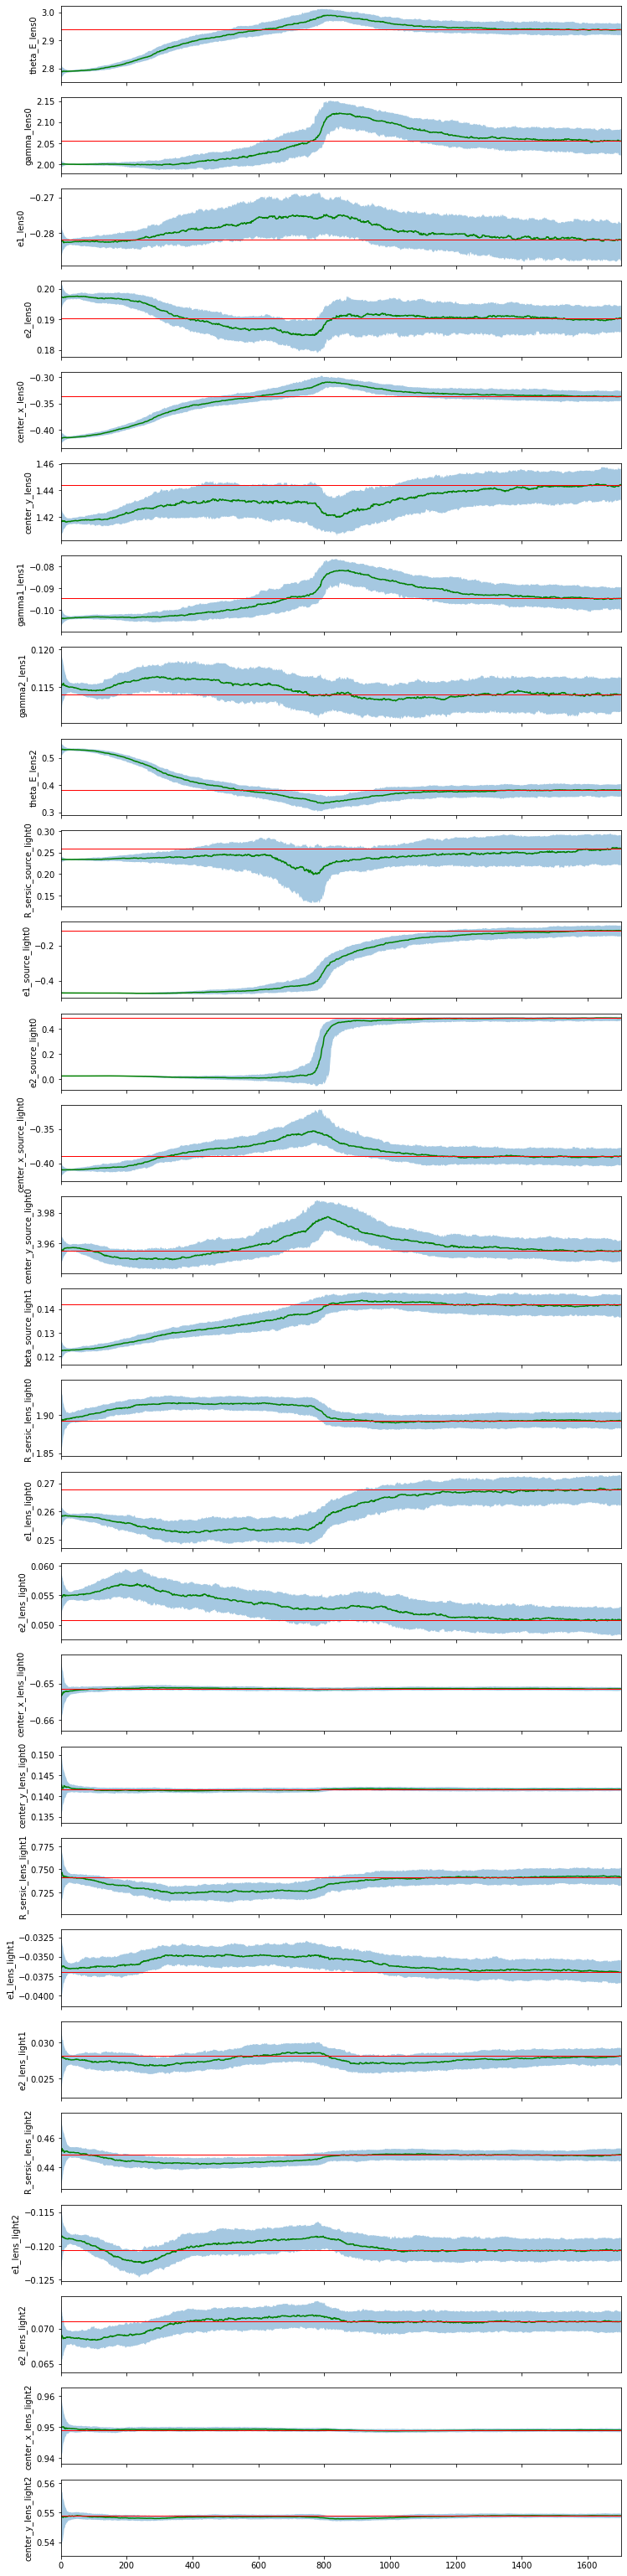

In [27]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 200
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

## Corner Plot

Number of non-linear parameters in the MCMC process: 28
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'theta_E_lens2', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1', 'R_sersic_lens_light2', 'e1_lens_light2', 'e2_lens_light2', 'center_x_lens_light2', 'center_y_lens_light2']
Number of evaluations in the MCMC process: 340400
340400
Shape of samples_mcmc_cut: (2200, 28)


/tmp/ipykernel_12574/3583671573.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


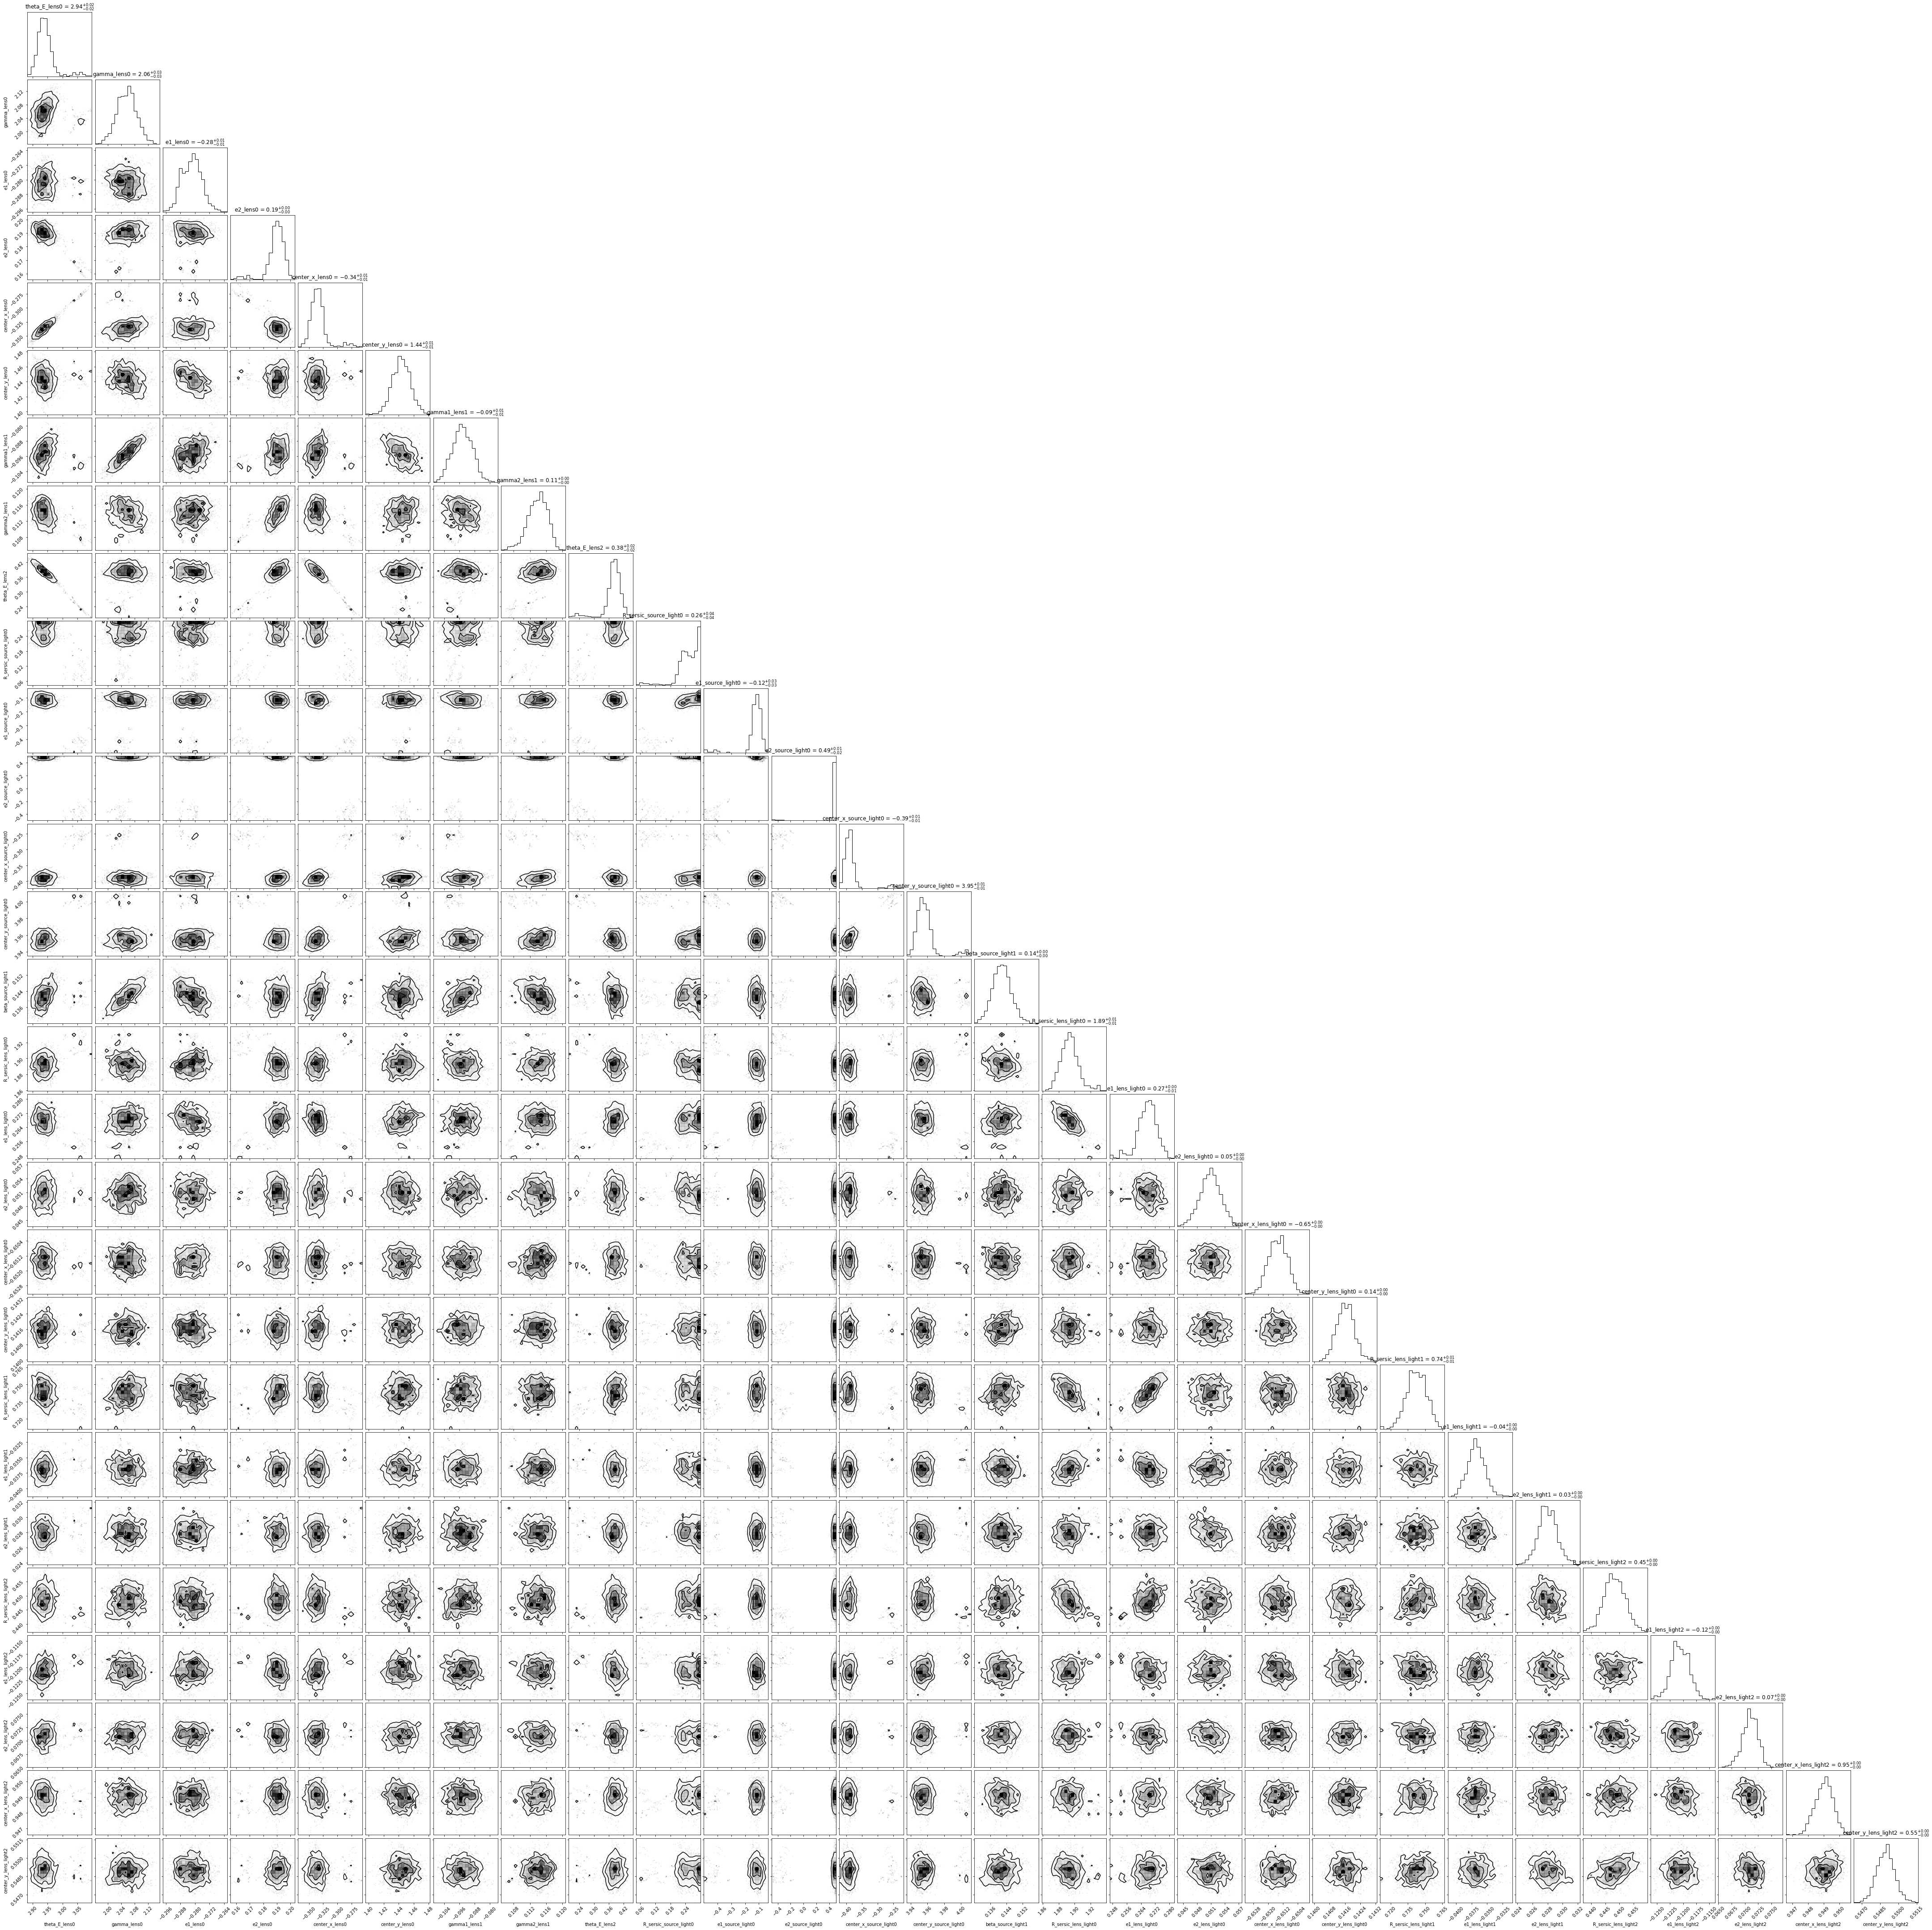

In [28]:
import corner
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 1500
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

## MCMC: Visualizing the Fitted Model

-0.9665953300082754 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9665953300082792


/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
/tmp/ipykernel_12574/3717568869.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


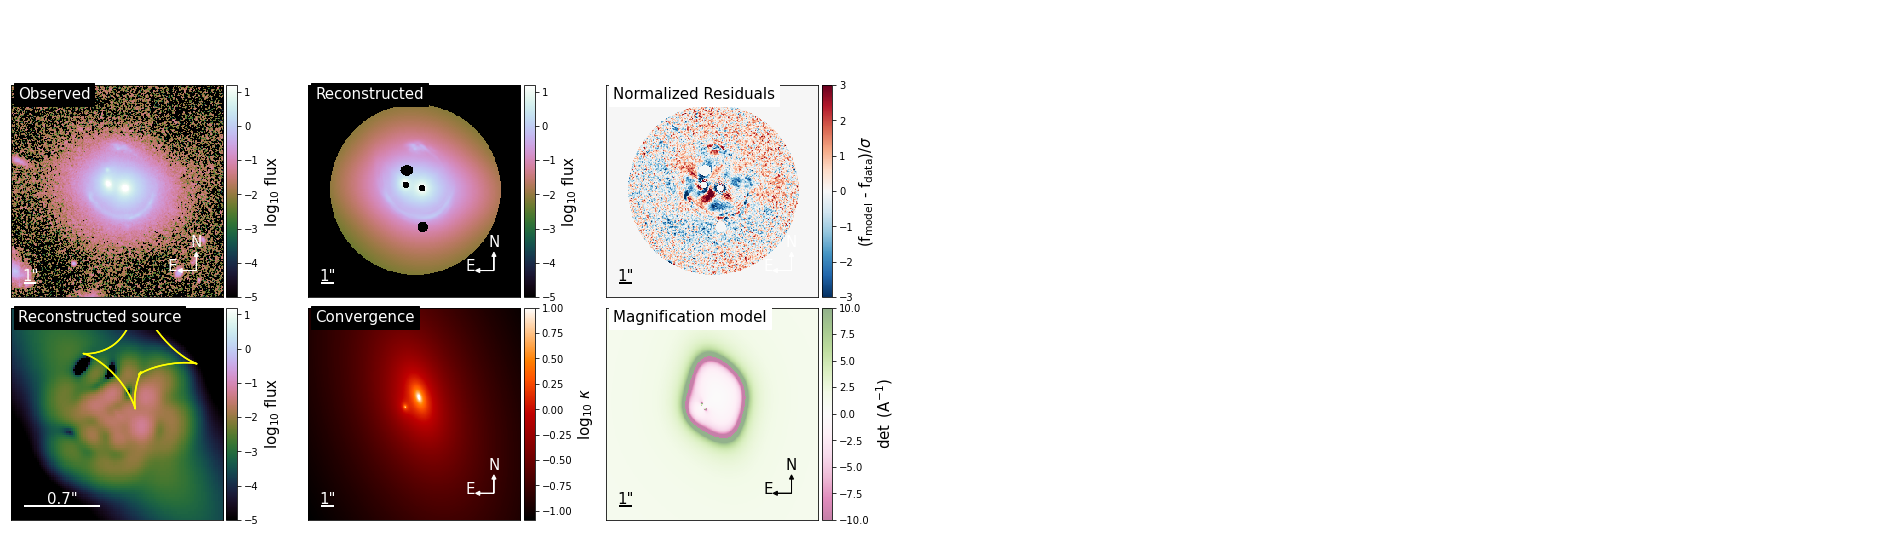

/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: divide by zero encountered in log10
  np.log10(model),


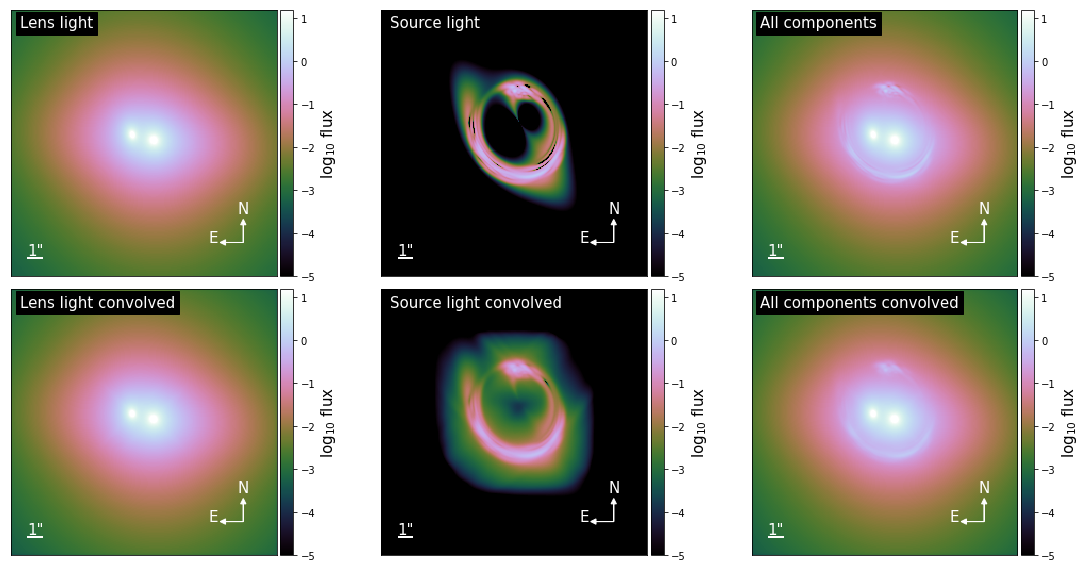

{'kwargs_lens': [{'theta_E': 2.927168801629469, 'gamma': 2.027758809087158, 'e1': -0.27789575198807775, 'e2': 0.1894683614461484, 'center_x': -0.34239138280644704, 'center_y': 1.4469698352646863}, {'gamma1': -0.09648093412356881, 'gamma2': 0.11439563147666, 'ra_0': 0.0, 'dec_0': 0.0}, {'theta_E': 0.3904810748302883, 'e1': -0.12062822711758402, 'e2': 0.0719532517775722, 'center_x': 0.949087847824601, 'center_y': 0.5492024499638223}], 'kwargs_source': [{'amp': 15.046096835816682, 'R_sersic': 0.2882028053123097, 'n_sersic': 1.0, 'e1': -0.11430063869559978, 'e2': 0.49457596736225123, 'center_x': -0.20599641095492222, 'center_y': 0.6825249261137216}, {'amp': array([ 70.17573253, -42.48210189,  -8.17025347, 121.07691269,
         3.11759662,  40.59891411, -58.66719454,  -1.651296  ,
       -23.18928083,  -2.41106127,  45.67542829, -18.72161326,
        12.0435213 , -29.55260535,  -0.41337993,  -2.81732705,
        18.20822664, -42.34046333,  -7.77734045, -11.37952016,
       -14.36840497,   

In [29]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, numPix=100, with_caustics=True, scale_size=0.7
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

## Mass and Light Ellipticity of the Lens Galaxy after the MCMC-run

In [30]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light0_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light0_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

result_light1_e1 = kwargs_result_mcmc["kwargs_lens_light"][1]["e1"]
result_light1_e2 = kwargs_result_mcmc["kwargs_lens_light"][1]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light0_phi, light0_q = ellipticity2phi_q(result_light0_e1, result_light0_e2)
light1_phi, light1_q = ellipticity2phi_q(result_light1_e1, result_light1_e2)
print(
    "mass_q: {},\nlight0_q: {}, \nlight1_q: {}".format(
        mass_q,
        light0_q,
        light1_q,
    )
)

mass_q: 0.49662558759931374,
light0_q: 0.5682764608035576, 
light1_q: 0.9109644260840525


## Save the Best Fit Parameters (MCMC)

In [31]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result_mcmc, multi_band_list_out, kwargs_fixed_out]

output_path = "DESIJ0136-0008_mcmc_output.joblib"
with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=9)